In [1]:
import sys
import os
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.append(parent_dir)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as opt
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.optim.lr_scheduler as lr_scheduler


from models.baseline import BaseLineModel
from models.transformer_encoder import TransEncoder
from ddpm.ddpm import GaussianDiffusion1D

from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, precision_recall_curve

## Data
seq_len = 12
batch_size = 256
k = 15

#NN
device = 'cuda' if torch.cuda.is_available() else 'cpu'
latent_dim = 256
cond_model = "mlp"
num_layers = 6
n_heads = 8
lr = 1e-4
betas = (0.9, 0.99)
epochs = 3000
save_rate = 100
decay_rate = 0.9

## DDPM
timesteps = 1000
beta_schedule = "cosine"
objective = "pred_noise"

model_name = "trans"
weights_dir = "../logging/trans_5kepoch_kmeans15_customer_seq12/weights/model_epoch_4500_val_0.2677.pth"

# Data

In [2]:
class MakeDATA(Dataset):
    def __init__(self, data, seq_len):
        data = np.asarray(data, dtype=np.float32)
        seq_data = []
        for i in range(len(data) - seq_len + 1):
            x = data[i : i + seq_len]
            seq_data.append(x)
        self.samples = np.asarray(seq_data, dtype=np.float32) 

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

In [3]:
def cluster(data, k):
    kmeans = KMeans(n_clusters=k)
    cluster_labels = kmeans.fit_predict(data.T)
    
    clustered_data = []
    for cluster in range(kmeans.n_clusters):
        cluster_data = data.iloc[:, cluster_labels == cluster].mean(axis=1)
        clustered_data.append(cluster_data)
        
    return pd.DataFrame(clustered_data).T

In [4]:
#taken from https://medium.com/@heyamit10/exponential-moving-average-ema-in-pytorch-eb8b6f1718eb
class EMA:
    def __init__(self, model, decay):
        """
        Initialize EMA class to manage exponential moving average of model parameters.
        
        Args:
            model (torch.nn.Module): The model for which EMA will track parameters.
            decay (float): Decay rate, typically a value close to 1, e.g., 0.999.
        """
        self.model = model
        self.decay = decay
        self.shadow = {}
        self.backup = {}

        # Store initial parameters
        for name, param in model.named_parameters():
            if param.requires_grad:
                self.shadow[name] = param.data.clone()

    def update(self):
        """
        Update shadow parameters with exponential decay.
        """
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                new_average = (1.0 - self.decay) * param.data + self.decay * self.shadow[name]
                self.shadow[name] = new_average.clone()

    def apply_shadow(self):
        """
        Apply shadow (EMA) parameters to model.
        """
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                self.backup[name] = param.data.clone()
                param.data = self.shadow[name]

    def restore(self):
        """
        Restore original model parameters from backup.
        """
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                param.data = self.backup[name]

def load_checkpoint(model, ema, optimizer, filepath):
    checkpoint = torch.load(filepath)
    model.load_state_dict(checkpoint['model_state_dict'])
    
    if 'ema_state_dict' in checkpoint:
        for name, param in model.named_parameters():
            if param.requires_grad and name in checkpoint['ema_state_dict']:
                ema.shadow[name] = checkpoint['ema_state_dict'][name].clone()
    
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [5]:
PREPROCESSED_DIR = "../preprocessing/data/customer_led_network_revolution/preprocessed/"

In [6]:
train = pd.read_csv(os.path.join(PREPROCESSED_DIR, "train.csv"))
train.drop("Date and Time of capture", axis=1, inplace=True)
train = cluster(train, k)
train_seq = np.asarray(MakeDATA(train, seq_len)).transpose(0, 2, 1)

test = pd.read_csv(os.path.join(PREPROCESSED_DIR, "test.csv"))
test.drop("Date and Time of capture", axis=1, inplace=True)
test = cluster(test, k)
test_seq = np.asarray(MakeDATA(test, seq_len)).transpose(0, 2, 1)

cond_train = pd.read_csv(os.path.join(PREPROCESSED_DIR, "cond_train.csv"))
cond_train_seq = np.asarray(MakeDATA(cond_train, seq_len)).transpose(0, 2, 1)

cond_test = pd.read_csv(os.path.join(PREPROCESSED_DIR, "cond_test.csv"))
cond_test_seq = np.asarray(MakeDATA(cond_test, seq_len)).transpose(0, 2, 1)

train_dataset = TensorDataset(torch.from_numpy(train_seq), torch.from_numpy(cond_train_seq))
train_loader = DataLoader(train_dataset, 256, shuffle=False)

test_dataset = TensorDataset(torch.from_numpy(test_seq), torch.from_numpy(cond_test_seq))
test_loader = DataLoader(test_dataset, 256, shuffle=False)

c:\Users\Arne\anaconda3\envs\hf_diff\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Arne\anaconda3\envs\hf_diff\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


In [7]:
if model_name == "unet":
    pass #preprocess data

In [8]:
if model_name == "trans":
    model = model = TransEncoder(features=train_seq.shape[1], latent_dim=latent_dim, num_heads=n_heads, num_layers=num_layers, cond_features=cond_train_seq.shape[1], cond_model=cond_model, device=device, seq_len=seq_len)

    ddpm = GaussianDiffusion1D(model, seq_length=seq_len, timesteps=timesteps, objective=objective, loss_type='l2', beta_schedule=beta_schedule)
    ddpm = ddpm.to(device)

    optim = torch.optim.Adam(ddpm.parameters(), lr=lr, betas=betas)

    ddpm.load_state_dict(torch.load(weights_dir)["diffusion_state_dict"])

if model_name == "baseline":
    model = BaseLineModel(seq_len=seq_len, hidden_dim=latent_dim, cond_dim=cond_train_seq.shape[1], cond_model=cond_model, device=device, channels=train_seq.shape[1])

    ddpm = GaussianDiffusion1D(model, seq_length = seq_len, timesteps = timesteps, objective = objective, loss_type = 'l2', beta_schedule = beta_schedule)
    ddpm = ddpm.to(device)
    ema = EMA(model, decay=decay_rate)

    optim = torch.optim.Adam(ddpm.parameters(), lr = lr)
    scheduler = lr_scheduler.StepLR(optim, step_size=1000, gamma=0.9)

    load_checkpoint(model, ema, optim, weights_dir)

c:\Users\Arne\anaconda3\envs\hf_diff\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
C:\Users\Arne\AppData\Local\Temp\ipykernel_22340\2492051251.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.seriali

In [9]:
real_data_train = []
generated_data_train = []

for idx, (data, cond) in enumerate(train_loader):
    if idx == 300:
        break
    
    if cond.shape[0] == data.shape[0] == 256:
        real_data_train.append(data)
        
        with torch.no_grad():
            
            samples = ddpm.sample(batch_size, cond.to(device))
            samples = samples.cpu().numpy()
        
        generated_data_train.append(samples)
    
generated_data = np.concatenate(real_data_train, axis=0)
real_data = np.concatenate(generated_data_train, axis=0)

generated_tensor = torch.tensor(generated_data, dtype=torch.float32)
real_tensor = torch.tensor(real_data, dtype=torch.float32)

generated_labels = torch.zeros(len(generated_tensor), dtype=torch.long)
real_labels = torch.ones(len(real_tensor), dtype=torch.long)

all_samples_train = torch.cat([generated_tensor, real_tensor], dim=0)
all_labels_train = torch.cat([generated_labels, real_labels], dim=0)

sampling loop time step: 100%|██████████| 1000/1000 [00:05<00:00, 172.22it/s]


In [10]:
real_data_test = []
generated_data_test = []

for idx, (data, cond) in enumerate(test_loader):
    if idx == 30:
        break
    if cond.shape[0] == data.shape[0] == 256:
        real_data_test.append(data)

        with torch.no_grad():
            samples = ddpm.sample(batch_size, cond.to(device))
            samples = samples.cpu().numpy()
        
        generated_data_test.append(samples)
    
generated_data = np.concatenate(real_data_test, axis=0)
real_data = np.concatenate(generated_data_test, axis=0)

generated_tensor = torch.tensor(generated_data, dtype=torch.float32)
real_tensor = torch.tensor(real_data, dtype=torch.float32)

generated_labels = torch.zeros(len(generated_tensor), dtype=torch.long)
real_labels = torch.ones(len(real_tensor), dtype=torch.long)

all_samples_test = torch.cat([generated_tensor, real_tensor], dim=0)
all_labels_test = torch.cat([generated_labels, real_labels], dim=0)

sampling loop time step: 100%|██████████| 1000/1000 [00:05<00:00, 173.38it/s]


In [11]:
class RealVsSyntheticDataset(Dataset):
    def __init__(self, samples, labels):
        self.samples = samples
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.samples[idx], self.labels[idx]

In [12]:
dataset = RealVsSyntheticDataset(all_samples_train, all_labels_train)
train_loader = DataLoader(dataset, batch_size=64, shuffle=True)

for x, y in train_loader:
    print(x.shape)  # (64, 15, 12)
    print(y.shape)  # (64,)
    break

torch.Size([64, 15, 12])
torch.Size([64])


# Model
## LSTM

In [13]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim=12, hidden_dim=64, num_layers=2):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_size=input_dim,
                            hidden_size=hidden_dim,
                            num_layers=num_layers,
                            batch_first=True)

        self.fc = nn.Linear(hidden_dim, 2)

    def forward(self, x):
        # x: (batch_size, seq_len=15, input_dim=12)
        lstm_out, _ = self.lstm(x)  
        last_hidden = lstm_out[:, -1, :]
        out = self.fc(last_hidden)      
        return out

## Transformer

In [14]:
class TransformerClassifier(nn.Module):
    def __init__(self, input_dim=12, num_heads=2, hidden_dim=64, num_layers=2, seq_len=15):
        super(TransformerClassifier, self).__init__()

        self.embedding = nn.Linear(input_dim, hidden_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim,
                                                   nhead=num_heads,
                                                   batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(hidden_dim, 2)

    def forward(self, x):
        # x: (batch, seq_len=15, input_dim=12)
        x = self.embedding(x) 
        x = self.transformer(x) 

        # Pool over the sequence dimension
        x = x.permute(0, 2, 1)  
        x = self.pool(x).squeeze(-1) 

        out = self.fc(x) 
        return out

In [15]:
# model = LSTMClassifier()
model = TransformerClassifier()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = opt.Adam(model.parameters(), lr=1e-3)

num_epochs = 10

train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_accuracy = correct / total * 100

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f} - Accuracy: {epoch_accuracy:.2f}%")

Epoch 1/10 - Loss: 0.5699 - Accuracy: 66.90%
Epoch 2/10 - Loss: 0.2880 - Accuracy: 87.08%
Epoch 3/10 - Loss: 0.1810 - Accuracy: 92.62%
Epoch 4/10 - Loss: 0.1328 - Accuracy: 94.79%
Epoch 5/10 - Loss: 0.1046 - Accuracy: 95.98%
Epoch 6/10 - Loss: 0.0882 - Accuracy: 96.65%
Epoch 7/10 - Loss: 0.0738 - Accuracy: 97.25%
Epoch 8/10 - Loss: 0.0669 - Accuracy: 97.50%
Epoch 9/10 - Loss: 0.0595 - Accuracy: 97.82%
Epoch 10/10 - Loss: 0.0543 - Accuracy: 97.91%


In [16]:
def evaluate(model, dataloader, device, plot=True):
    model.eval()
    correct = 0
    total = 0

    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            probs = torch.softmax(outputs, dim=1)[:, 1]  # probability for "synthetic" class
            _, predicted = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total * 100

    if plot:
        all_labels = torch.tensor(all_labels)
        all_preds = torch.tensor(all_preds)
        all_probs = torch.tensor(all_probs)

        # 1. Confusion Matrix
        cm = confusion_matrix(all_labels, all_preds)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Real", "Synthetic"])
        disp.plot(cmap="Blues")
        plt.title("Confusion Matrix")
        plt.show()

        # 2. ROC Curve
        fpr, tpr, _ = roc_curve(all_labels, all_probs)
        roc_auc = auc(fpr, tpr)
        plt.figure()
        plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend()
        plt.grid(True)
        plt.show()

        # 3. Precision-Recall Curve
        precision, recall, _ = precision_recall_curve(all_labels, all_probs)
        plt.figure()
        plt.plot(recall, precision, label='PR Curve')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.grid(True)
        plt.legend()
        plt.show()

    return f"Model Test Accuracy: {accuracy}"

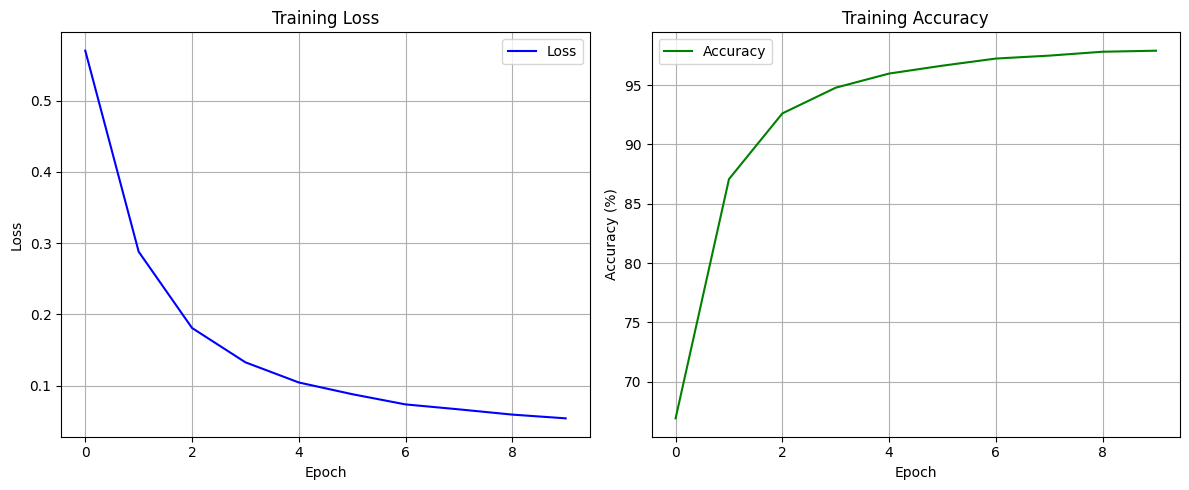

In [17]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Loss", color='blue')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Accuracy", color='green')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training Accuracy")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Eval

In [18]:
dataset = RealVsSyntheticDataset(all_samples_test, all_labels_test)
test_loader = DataLoader(dataset, batch_size=64, shuffle=True)

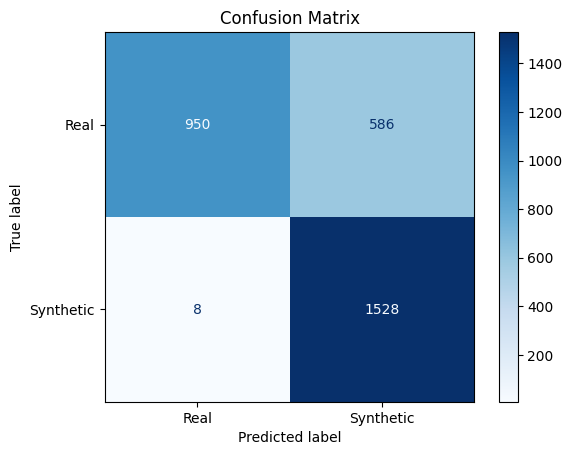

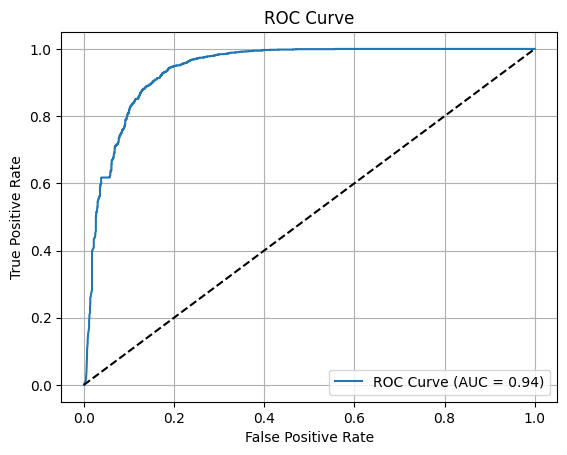

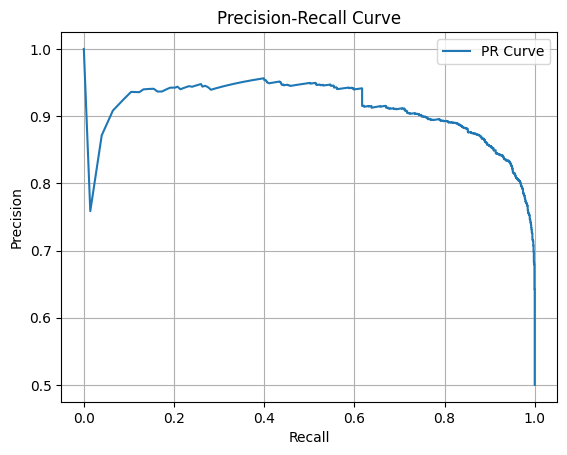

'Model Test Accuracy: 80.6640625'

In [19]:
evaluate(model, test_loader, device)